In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load libraries and packages

In [49]:
import joblib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Utility function

In [50]:
from utils import clean_text, DenseTransformer

In [51]:
dt = pd.read_csv('imdb_labelled.txt', delimiter = '\t', names=["reviews", "rating"])
dt.head(4)

,reviews,rating
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0


# Missing values

In [52]:
dt.isnull().sum()

reviews    0
rating     0
dtype: int64

# Labelling creation

In [53]:
dt['labels'] = dt["rating"].apply(lambda x: "Positive" if x else "Negative")
dt.head(4)

,reviews,rating,labels
0,"A very, very, very slow-moving, aimless movie ...",0,Negative
1,Not sure who was more lost - the flat characte...,0,Negative
2,Attempting artiness with black & white and cle...,0,Negative
3,Very little music or anything to speak of.,0,Negative


# Label length of words in document

In [54]:
dt['length'] = dt['reviews'].apply(lambda x: len(str(x).split(' ')))
dt.head(4)

,reviews,rating,labels,length
0,"A very, very, very slow-moving, aimless movie ...",0,Negative,15
1,Not sure who was more lost - the flat characte...,0,Negative,21
2,Attempting artiness with black & white and cle...,0,Negative,33
3,Very little music or anything to speak of.,0,Negative,10


# Length of words in each document 

In [55]:
dt['length'].unique()

array([  15,   21,   33,   10,   23,   22,    5,   17,   12,    8,   13,
          6,   18,   25,   19,  868,   14,   16,    9,    7,   26,   35,
         11,    4,   27,   28,    3,   20,   37,   24,   36,  201, 1393,
         49,   30,  306,   31,   32,   44,   56,   45,   34,   38,   64,
         58,   40,   47,   29,   73,   41,   39,   55,   53,   42,  800],
      dtype=int64)

# Distribution of words in document

<BarContainer object of 55 artists>

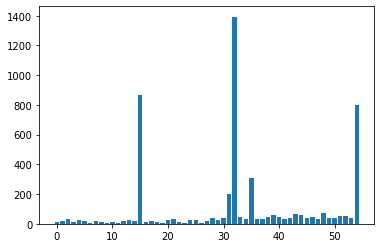

In [56]:
unique_lengths = dt['length'].unique()
plt.bar(np.arange(len(unique_lengths)), unique_lengths)

In [57]:
print(dt['labels'].value_counts())


Positive    386
Negative    362
Name: labels, dtype: int64


# Apply clean text function

In [58]:
dt['clean_review'] = movie['reviews'].apply(clean_text)
dt.head()

,reviews,rating,labels,length,clean_review
0,"A very, very, very slow-moving, aimless movie ...",0,Negative,15,a very very very slowmoving aimless movie abou...
1,Not sure who was more lost - the flat characte...,0,Negative,21,not sure who wa more lost the flat character o...
2,Attempting artiness with black & white and cle...,0,Negative,33,attempting artiness with black white and cleve...
3,Very little music or anything to speak of.,0,Negative,10,very little music or anything to speak of
4,The best scene in the movie was when Gerardo i...,1,Positive,23,the best scene in the movie wa when gerardo is...


# Text Preprocessing

In [59]:
X = movie['reviews']
y = movie['rating']

# Split train and test sets into proportions

In [60]:
token, X_test, y_train, y_test = train_test_split(X,y, test_size = .40, random_state = 60)


In [61]:
token.shape, token.to_list()[:4]


((448,),
 ['I am so tired of clichés that is just lazy writing, and here they come in thick and fast.  ',
  'Nothing short of magnificent photography/cinematography in this film.  ',
  'The acting was bad, the dialogs were extremely shallow and insincere.  ',
  "The soundtrack wasn't terrible, either.  "])

# Train data with countVectorizer and Complement NB

In [62]:
cv_nb = Pipeline([
    ('Bag_of_words', CountVectorizer(stop_words = 'english')), 
    ('classifier', ComplementNB()),
])

In [63]:
cv_nb.fit(token, y_train)


Pipeline(steps=[('Bag_of_words', CountVectorizer(stop_words='english')),
                ('classifier', ComplementNB())])

In [64]:
joblib.dump(cv_nb, "models/complement_naive_bayes_with count_vectorizer.joblib")


['models/complement_naive_bayes_with count_vectorizer.joblib']

In [65]:
model_pred = cv_nb.predict(X_test)


In [66]:
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       155
           1       0.72      0.79      0.75       145

    accuracy                           0.75       300
   macro avg       0.75      0.75      0.75       300
weighted avg       0.75      0.75      0.75       300



# Train data with tfidf and complementNB

In [68]:
tfidf_nb = Pipeline([
    ('Bag_of_words', TfidfVectorizer(stop_words = 'english')), 
    ('classifier', ComplementNB()),
])

In [69]:
tfidf_nb.fit(token, y_train)


Pipeline(steps=[('Bag_of_words', CountVectorizer(stop_words='english')),
                ('classifier', ComplementNB())])

In [75]:
joblib.dump(tfidf_nb, "models/complement_naive_bayes_with tfidf_vectorizer.joblib")


['models/complement_naive_bayes_with count_vectorizer.joblib']

In [76]:
model_pred_tf = tfidf_nb.predict(X_test)


In [77]:
print(classification_report(y_test, model_pred_tf))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       155
           1       0.92      0.92      0.92       145

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



# Cross validation for tfidf on the data

In [72]:
accurancy = []
stratifiedKf_predict = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
stratifiedKf_predict.get_n_splits(X,y)

for train_index, test_index in stratifiedKf_predict.split(X,y):
   
    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
    y1_train, y1_test = y.iloc[train_index], y.iloc[test_index]
  
    tfidf_nb.fit(X1_train, y1_train)
    result = tfidf_nb.score(X1_test, y1_test)
    accurancy.append(result)

accuracy = np.array(accurancy)

#Print the output
print('list of first 10 possible accurancy:')

for index, acc in enumerate(accuracy[:10]):
    print(f' {index+1:3d}. {acc:.4f}')


print('\nMetrics that were obtained from this model:')
print(f' Maximum Accurancy: {accuracy.max()*100:.2f}%')
print(f' Minimum Accurancy: {accuracy.min()*100:.2f}%')
print(f' Mean Accurancy: {accuracy.mean()*100:.2}%')
print(f' Std accurancy: {accuracy.std()*100:.2f}%')
print(accurancy)

print(accurancy)

list of first 10 possible accurancy:
   1. 0.7800
   2. 0.7933
   3. 0.7600
   4. 0.7517
   5. 0.7315

Metrics that were obtained from this model:
 Maximum Accurancy: 79.33%
 Minimum Accurancy: 73.15%
 Mean Accurancy: 7.6e+01%
 Std accurancy: 2.16%
[0.78, 0.7933333333333333, 0.76, 0.7516778523489933, 0.7315436241610739]
[0.78, 0.7933333333333333, 0.76, 0.7516778523489933, 0.7315436241610739]


# Cross validation for count_vectorizer on the data

In [78]:
accurancy = []
stratifiedKf_predict = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
stratifiedKf_predict.get_n_splits(X,y)

for train_index, test_index in stratifiedKf_predict.split(X,y):
   
    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
    y1_train, y1_test = y.iloc[train_index], y.iloc[test_index]
  
    cv_nb.fit(X1_train, y1_train)
    result = cv_nb.score(X1_test, y1_test)
    accurancy.append(result)

accuracy = np.array(accurancy)

#Print the output
print('list of first 10 possible accurancy:')

for index, acc in enumerate(accuracy[:10]):
    print(f' {index+1:3d}. {acc:.4f}')


print('\nMetrics that were obtained from this model:')
print(f' Maximum Accurancy: {accuracy.max()*100:.2f}%')
print(f' Minimum Accurancy: {accuracy.min()*100:.2f}%')
print(f' Mean Accurancy: {accuracy.mean()*100:.2}%')
print(f' Std accurancy: {accuracy.std()*100:.2f}%')
print(accurancy)

print(accurancy)

list of first 10 possible accurancy:
   1. 0.7467
   2. 0.7867
   3. 0.7067
   4. 0.7450
   5. 0.7383

Metrics that were obtained from this model:
 Maximum Accurancy: 78.67%
 Minimum Accurancy: 70.67%
 Mean Accurancy: 7.4e+01%
 Std accurancy: 2.55%
[0.7466666666666667, 0.7866666666666666, 0.7066666666666667, 0.7449664429530202, 0.738255033557047]
[0.7466666666666667, 0.7866666666666666, 0.7066666666666667, 0.7449664429530202, 0.738255033557047]
